# Importing some Libraries


In [5]:
# !pip install scikit-learn

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import shutil
from sklearn.model_selection import train_test_split

# Loading ImageNet dataset

In [7]:
# Step 1.1: Define the dataset directory path
dataset_dir = 'C:/Users/HP-Miko/Desktop/imageNet dataset/dataset'

In [8]:
# Step 1.2: Split the dataset into training and validation
# Create directories path!!!!!!!!!
train_dir = 'C:/Users/HP-Miko/Desktop/imageNet dataset/train'
val_dir = 'C:/Users/HP-Miko/Desktop/imageNet dataset/val'

In [9]:
# generating a new dictionary
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Data Preprocessing

In [10]:
# Step 1.3: Split each class folder into train and validation sets (80/20 split)
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):  # Ignore any non-folder files
        # Get all image files in the class folder
        all_images = os.listdir(class_path)
        train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

        # Create class directories inside train and val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Move the images to their respective directories
        for image in train_images:
            shutil.move(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
        for image in val_images:
            shutil.move(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))
        

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [12]:
# Step 1.4: Load the training and validation datasets using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='int',
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode='int',
    shuffle=False
)

Found 431480 files belonging to 1000 classes.
Found 108346 files belonging to 1000 classes.


In [13]:
class_names = train_dataset.class_names
print(f"Total classes: {len(class_names)}")
print(f"First few class names: {class_names[:5]}")

Total classes: 1000
First few class names: ['abacus', 'abaya', 'academic_gown', 'accordion', 'acorn']


In [14]:
# Step 1.5: Normalize the pixel values            # THIS CODE IS TOO ADVANCED VANNY
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)

In [15]:
# Step 1.6: Prefetch data for better performance
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
# Step 1.7: Check class names (optional)
print(f"Total classes: {len(class_names)}")
print(f"First few class names: {class_names[:5]}")

Total classes: 1000
First few class names: ['abacus', 'abaya', 'academic_gown', 'accordion', 'acorn']


# Building CNN Model

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7104408382083613842
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10046511513
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1335640275128181237
physical_device_desc: "device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:15:00.0, compute capability: 6.1"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10046511513
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4690211649423845402
physical_device_desc: "device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:2d:00.0, compute capability: 6.1"
xla_global_id: 2144165316
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 10046511513
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11368422746268010905
physical_device_desc: "device: 2, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:99:00.0, compute capability: 6.1"
xla_global_id: 1651660799
]


In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  3


In [19]:

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus}")
else:
    print("❌ No GPU detected. TensorFlow is using CPU.")

✅ GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [20]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Show all logs

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import datetime
from tensorflow.keras.callbacks import TensorBoard

# Create a logs directory with a timestamp
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Load the base model (pretrained on ImageNet)
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,  # Exclude the original final layer
                         weights='imagenet')
base_model.trainable = False  # Freeze the base

# Add your own classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # thousands of classes!
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[tensorboard_callback]
)

model.evaluate(val_dataset)
model.save('my_model.h5')

Epoch 1/20
6742/6742 [==============================] - 671s 98ms/step - loss: 1.8869 - accuracy: 0.5776 - val_loss: 1.1495 - val_accuracy: 0.7058
Epoch 2/20
6742/6742 [==============================] - 679s 101ms/step - loss: 1.5547 - accuracy: 0.6391 - val_loss: 1.1567 - val_accuracy: 0.7119
Epoch 3/20
6742/6742 [==============================] - 680s 101ms/step - loss: 1.5225 - accuracy: 0.6502 - val_loss: 1.2050 - val_accuracy: 0.7101
Epoch 4/20
6742/6742 [==============================] - 681s 101ms/step - loss: 1.4987 - accuracy: 0.6580 - val_loss: 1.2494 - val_accuracy: 0.7085
Epoch 5/20
6742/6742 [==============================] - 680s 101ms/step - loss: 1.4890 - accuracy: 0.6627 - val_loss: 1.2914 - val_accuracy: 0.7086
Epoch 6/20
6742/6742 [==============================] - 678s 100ms/step - loss: 1.4857 - accuracy: 0.6658 - val_loss: 1.3282 - val_accuracy: 0.7069
Epoch 7/20
6742/6742 [==============================] - 681s 101ms/step - loss: 1.4854 - accuracy: 0.6688 - val_l

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

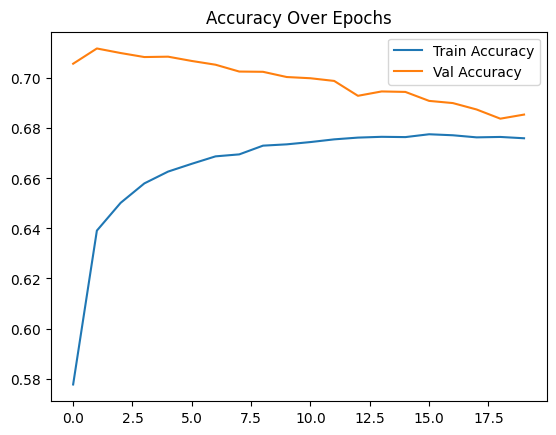

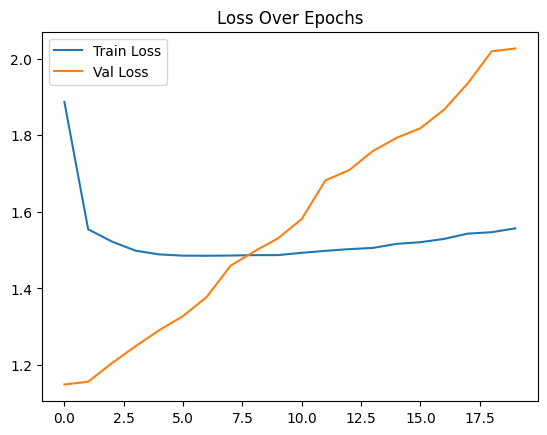

In [22]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()
